<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/Prohibited_language_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prohibited Language classification

Classification of foul language task using Bag of Words embeddings, TF-IDF, word vectors


## Imports

In [1]:
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [2]:
%matplotlib inline

## Load dataset

In [3]:
%%capture
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/NLP/Text_classification/data/comments.tsv

In [4]:
data = pd.read_csv('comments.tsv', sep='\t')

## Some basic EDA

In [5]:
data.head()

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   should_ban    1000 non-null   int64 
 1   comment_text  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<Axes: xlabel='should_ban', ylabel='count'>

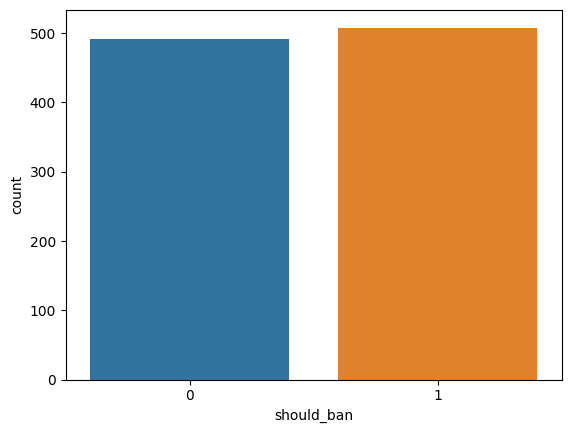

In [7]:
sns.countplot(data=data, x='should_ban')

In [8]:
data[data['comment_text'].str.len() <= 18]

,should_ban,comment_text
870,0,"No takers, then? ¦"


In [9]:
data[data['comment_text'].str.len() >=280]['comment_text'].count()

315

## Split data

In [10]:
X = data['comment_text'].values #data.drop('should_ban', axis=1)
y = data['should_ban'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Tokenize data

In [11]:
tokenizer = TweetTokenizer()
toker = lambda txt: ' '.join(tokenizer.tokenize(txt.lower()))
display(X_test[89])
toker(X_test[89])

'heY TOdds! Quick Q? \n\nWhy Are You So Gay'

'hey todds ! quick q ? why are you so gay'

In [12]:
v_tok = np.vectorize(toker)
texts_train = v_tok(X_train) #np.array([toker(x) for x in X_test])
texts_test = v_tok(X_test)

### Bathe in tests

In [13]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

## Baseline

In [14]:
tfidf = TfidfVectorizer(tokenizer=tokenizer.tokenize)
X_train_tfidf = tfidf.fit_transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.738
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       231
           1       0.78      0.71      0.75       269

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



## Write word counter over all documents

In [15]:
def get_freq_words(documents: np.ndarray)-> dict:
  '''Counts the number of words in all documents. Returns a dict {word:number}'''
  frequent_words = {}
  for doc in documents:
    doc = doc.split()
    for word in doc:
      frequent_words[word] = frequent_words.get(word, 0) +1
  return frequent_words


def sort_freq_words(word_freq: dict, k: int)-> list:
  '''Returns a sorted by occurency list of words with most frequent being first'''
  return sorted(word_freq.items(), key=lambda items: items[1], reverse=True)[:k]

In [16]:
k = 10000
word_frequency = get_freq_words(texts_train)
sorted_words = sort_freq_words(word_frequency, k)
bow_vocabulary = [token for token, n in sorted_words]
bow_vocabulary[:10]

['.', ',', 'you', 'the', '"', 'a', 'to', 'i', 'and', '!']

## Create Bag of Words embeddings

In [17]:
def text_to_bow(text: str)-> np.ndarray:
    """Convert text string to an array of token counts. Use bow_vocabulary."""
    bow_vector = np.zeros(len(bow_vocabulary))
    for word in text.split():
        if word in bow_vocabulary:
            bow_vector[bow_vocabulary.index(word)] += 1
    return bow_vector

In [18]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

### Bathe in tests

In [19]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

# Naive bayes

In [127]:
class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        self.p_y = np.array([np.mean(y==0), np.mean(y==1)])

        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = np.sum(X[y==1], axis=0)
        word_counts_negative = np.sum(X[y==0], axis=0)
        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1
        total_positive_words = np.sum(word_counts_positive) + BinaryNaiveBayes.delta * X.shape[1]
        total_negative_words = np.sum(word_counts_negative) + BinaryNaiveBayes.delta * X.shape[1]

        self.p_x_given_positive = (word_counts_positive + BinaryNaiveBayes.delta) / total_positive_words
        self.p_x_given_negative = (word_counts_negative + BinaryNaiveBayes.delta) / total_negative_words
        # both must be of shape [vocab_size]; and don't forget to add self.delta!
        print(self.p_x_given_positive.shape, self.p_x_given_negative.shape)
        return self


    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X
        score_negative = np.log(self.p_y[0]) + np.sum(np.log(self.p_x_given_negative)*X, axis=1)
        score_positive = np.log(self.p_y[1]) + np.sum(np.log(self.p_x_given_positive)*X, axis=1)

        # you can compute total p(x | y=k) with a dot product
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)


    def get_ratio(self):
        probability_ratio = self.p_x_given_negative / self.p_x_given_positive
        return np.argsort(probability_ratio)

    def get_ratio_in_vocab(self, vocab):
      return [self.p_x_given_negative[i] / self.p_x_given_positive[i] for i in range(len(vocab))]

In [128]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

(5707,) (5707,)


### Bathe in tests

In [123]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


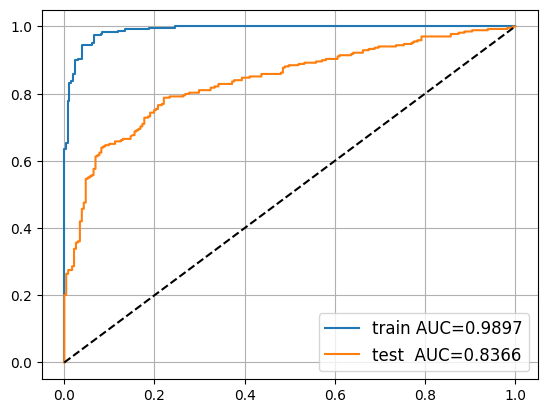

In [124]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

In [131]:
# hint: use naive_model.p_*
probability_ratio = naive_model.get_ratio() #<YOUR CODE: compute the ratio as defined above, must be a vector of [vocab_size]>
top_negative_words = [bow_vocabulary[i] for i in probability_ratio[:25]] #<YOUR CODE: find 25 words with highest probability_ratio, return list of str>


In [132]:
assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=337)
#1	      heil	(ratio=333)
#2	   offfuck	(ratio=380)
#3	      suck	(ratio=208)
#4	    nigger	(ratio=717)
#5	 j.delanoy	(ratio=686)
#6	      dick	(ratio=766)
#7	      fggt	(ratio=295)
#8	     bitch	(ratio=1354)
#9	      fuck	(ratio=1340)
#10	      slap	(ratio=1791)
#11	      shit	(ratio=1796)
#12	   fucking	(ratio=1588)
#13	       ass	(ratio=1604)
#14	    stupid	(ratio=2318)
#15	         =	(ratio=181)
#16	   college	(ratio=836)
#17	         *	(ratio=776)
#18	   asshole	(ratio=787)
#19	         u	(ratio=1593)
#20	   bastard	(ratio=3239)
#21	       hit	(ratio=3543)
#22	     idiot	(ratio=3459)
#23	         @	(ratio=3394)
#24	scientific	(ratio=2379)


In [149]:
bow_vocabulary[337]

'college'

#### The output words are right, but something seems wrong with the ratio interpretation

In [164]:
n_word = lambda n: bow_vocabulary[probability_ratio[n]]
n_score = lambda n: naive_model.p_x_given_negative[probability_ratio[n]] / naive_model.p_x_given_positive[probability_ratio[n]]
print(f'{n_word(0)}: {n_score(0)}')

hitler: 0.0021031669981914822


In [171]:
for i in range(len(top_negative_words)):
  print(f'{i+1}: {n_word(i)} {round(n_score(i),5)}')


1: hitler 0.0021
2: heil 0.00212
3: offfuck 0.00227
4: suck 0.00318
5: nigger 0.00447
6: j.delanoy 0.00455
7: dick 0.00535
8: fggt 0.01023
9: bitch 0.0167
10: fuck 0.01859
11: slap 0.02273
12: shit 0.02273
13: fucking 0.03147
14: ass 0.03719
15: stupid 0.05454
16: = 0.05701
17: college 0.05844
18: * 0.05844
19: asshole 0.06293
20: u 0.06545
21: bastard 0.06818
22: hit 0.06818
23: idiot 0.07438
24: @ 0.07438
25: scientific 0.08181


But since we are not allowed to change the test part let's consider the following code

In [119]:
from functools import cmp_to_key

inverted_bow = {word: idx for idx, word in enumerate(bow_vocabulary)}
proba_ratio = naive_model.get_ratio_in_vocab(bow_vocabulary)
top_neg_w = [w for w, idx in sorted(inverted_bow.items(), key=cmp_to_key(lambda i1, i2: proba_ratio[i1[1]]-proba_ratio[i2[1]]))][:25]

In [120]:
assert len(top_neg_w) == 25 and [isinstance(w, str) for w in top_neg_w]
assert 'j.delanoy' in top_neg_w and 'college' in top_neg_w

for i, word in enumerate(top_neg_w):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={proba_ratio[bow_vocabulary.index(word)]})")

#0	    hitler	(ratio=0.0021031669981914822)
#1	      heil	(ratio=0.00211951285569038)
#2	   offfuck	(ratio=0.002266293524366999)
#3	      suck	(ratio=0.003177211504064026)
#4	    nigger	(ratio=0.004470666460636539)
#5	 j.delanoy	(ratio=0.004545177568313815)
#6	      dick	(ratio=0.005347267727428018)
#7	      fggt	(ratio=0.010226649528706083)
#8	     bitch	(ratio=0.016696570659111974)
#9	      fuck	(ratio=0.01859390823401106)
#10	      shit	(ratio=0.022725887841569075)
#11	      slap	(ratio=0.022725887841569075)
#12	   fucking	(ratio=0.031466613934480255)
#13	       ass	(ratio=0.03718781646802212)
#14	    stupid	(ratio=0.05454213081976578)
#15	         =	(ratio=0.05701268029940674)
#16	         *	(ratio=0.05843799730689191)
#17	   college	(ratio=0.05843799730689191)
#18	   asshole	(ratio=0.06293322786896051)
#19	         u	(ratio=0.06545055698371893)
#20	   bastard	(ratio=0.06817766352470722)
#21	       hit	(ratio=0.06817766352470722)
#22	     idiot	(ratio=0.07437563293604424)
#23	     